### Zadanie 1

Przy trenowaniu używaliśmy już wcześniej kilku callbacków:
* ModelCheckpoint
* CSVLogger
* EarlyStopping

Do tego dodaliśmy kilka kolejnych, które są opisanie poniżej.

#### TerminateOnNaN

Czasami funkcja straty zwraca NaN. U nas działo się tak gdy używaliśmy `tanh` jako funkcji aktywacji. Takie trenowanie nie przynosi dobrych rezultatów i warto je przerwać odrazu. Jest to sczególnie przydatne, gdy chcemy zostawić na noc kilka różnych strategii do wytrenowania.

In [ ]:
terminate_on_nan = TerminateOnNaN()

Funkcja nie wymaga żadnych argumentów i jest prosta w używaniu. Niestety, jak można zauważyć w pliku `terminate_nan_logs.txt`, ona wykonuje się po każdym kroku, ale kończy działanie po skończeniu epoki. Dodatkowo zostawia nieczytelne i długi logi.
A na koniec epoki wykonują się inne callbacki, przez co pojawiają się dodatkowe wyjątki, które trzeba przeczytać.

Dlatego zdecydowaliśmy się na modyfikację tego callbacka, tak by zamykał program po wykryciu NaN.

In [ ]:
class CustomTerminateOnNaN(Callback):
  def __init__(self):
    super(CustomTerminateOnNaN, self).__init__()
    self._supports_tf_logs = True

  def on_batch_end(self, batch, logs=None):
    logs = logs or {}
    loss = logs.get('loss')
    if loss is not None:
      loss = tf_utils.to_numpy_or_python_type(loss)
      if np.isnan(loss) or np.isinf(loss):
        print('Batch %d: Invalid loss, terminating training' % (batch))
        sys.exit(1)

Logi po uruchomieniu sieci z naszym callbackiem są w pliku `custom_terminate_nan_logs.txt`. Są one znacznie mniejsze i oszczędzają czas, ponieważ nie liczą się niepotrzebnie dalsze kroki.

#### LearningRateScheduler

Ten callback pozwala kontrolować larning rate w każdej epoce. Nasza konfiguracja wyglądała tak

In [ ]:
def schedule_lr(epoch, lr):
    return lr * 0.94
lr_scheduler = LearningRateScheduler(schedule_lr)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
strategies = [
    {'lr': 1, 'modelid': 'model-3f722e11-cdba-46ac-a188-9ca5fe1e7cd5'},
    {'lr': 0.94, 'modelid': 'model-37837a8d-6cea-47c2-8414-a4b4fd377615'}
]
for strat in strategies:
    strat['log'] = pd.read_csv('/opt/notebooks/LungNetNew/' + strat['modelid'] + '/training.log')

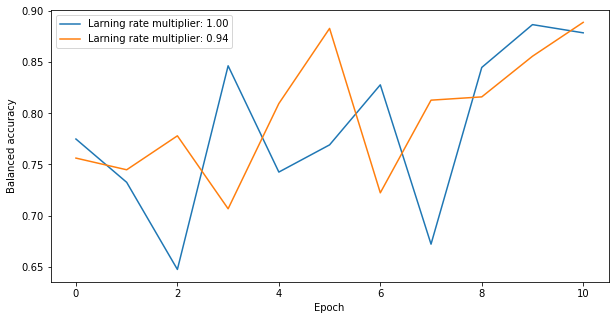

In [22]:
plt.rcParams["figure.figsize"] = (10,5)
for strat in strategies:
    plt.plot(strat['log']['epoch'], strat['log']['val_waccOA'], label='Larning rate multiplier: %0.2f' % strat['lr'])
plt.legend()
plt.ylabel('Balanced accuracy')
plt.xlabel('Epoch')
plt.show()

Nie widać istotnej różnicy mimo, że w 11 epoce learning rate jest już dwa razy mniejsze niż w orginalnej sieci.

#### TensorBoard

Dodaliśmy też callback do tensorflow. Przykładowy wykres analogowy do powyższego, ale z tb znajduje się poniżej.

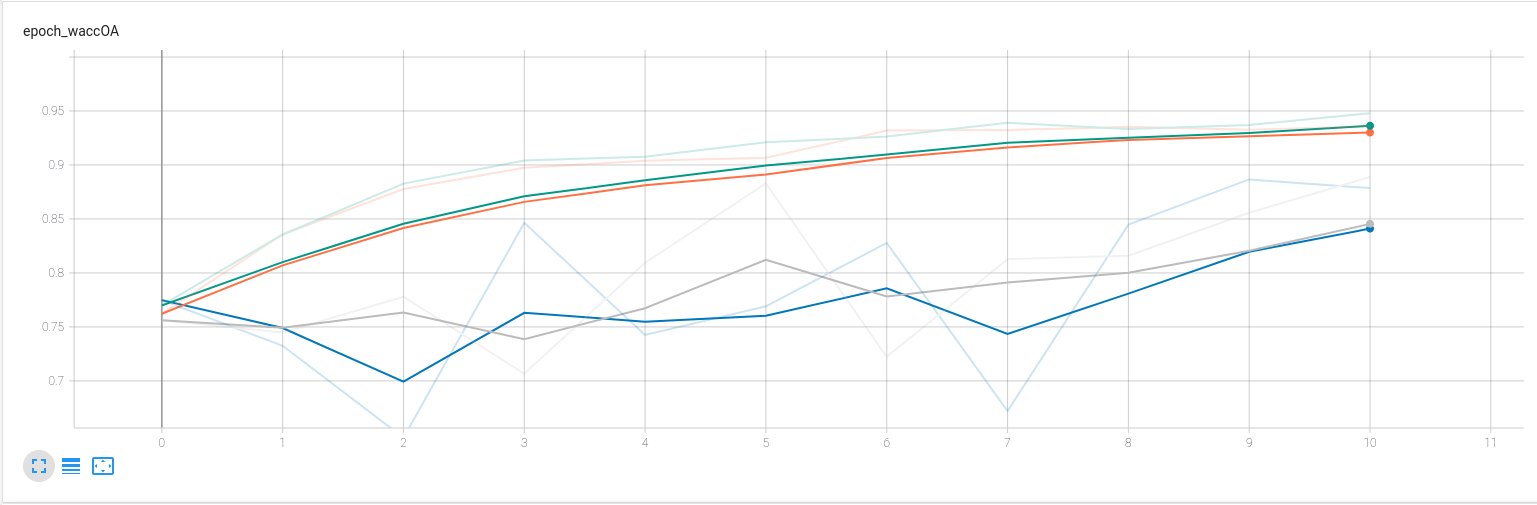

Wygładzanie wydaje się przydatne, ale brakuje w tym narzędziu modyfikowywalnych legend do wykresów, tak by można oznaczyć która krzywa tyczy się którego modelu.